In [1]:
# Get the data
import pandas as pd
import numpy as np
insurance = pd.read_csv("insurance.csv")
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [2]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A2BE5D9780>,
      dtype=object)

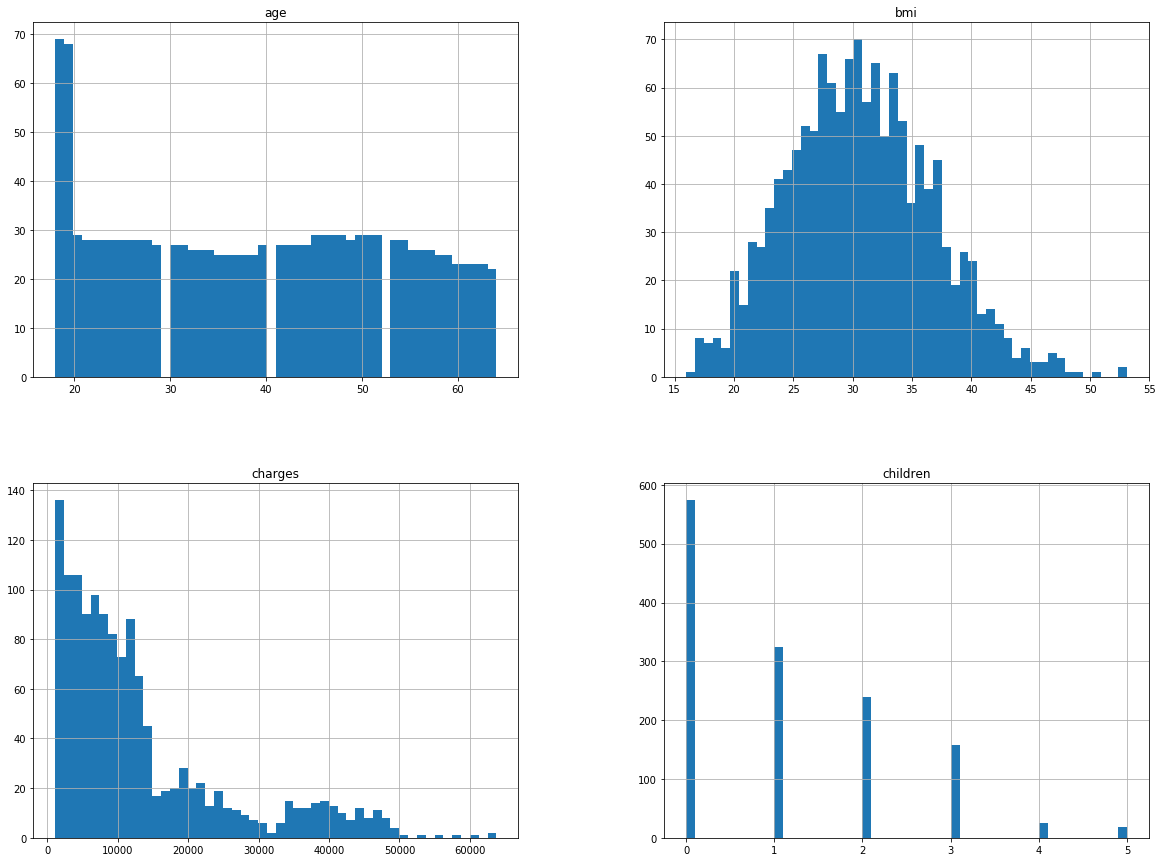

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
insurance.hist(bins=50, figsize=(20,15))

In [4]:
corr_matrix = insurance.corr()
corr_matrix.head()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


In [5]:
# Get the correlation between the input and output
corr_matrix["charges"].sort_values(ascending=False)

charges     1.000000
age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64

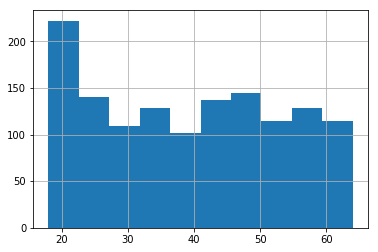

In [6]:
insurance["age"].hist()

In [7]:
insurance_stra = insurance.copy()
insurance_stra["age_cat"] = np.ceil(insurance_stra["age"] / 7)
#insurance_stra["age_cat"].where(housing["age_cat"] < 5, 5.0, inplace=True)
insurance_stra["age_cat"].value_counts()

7.0     198
4.0     196
8.0     195
3.0     194
5.0     184
6.0     181
9.0     168
10.0     22
Name: age_cat, dtype: int64

In [8]:
# Stratified ShuffleSplit cross-validator
# Every age select some people to become test set
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(insurance_stra, insurance_stra["age_cat"]):
    strat_train_set = insurance.loc[train_index]
    strat_test_set = insurance.loc[test_index]
strat_test_set.head()

,age,sex,bmi,children,smoker,region,charges
641,42,male,28.31,3,yes,northwest,32787.45859
959,48,male,36.67,1,no,northwest,28468.91901
21,30,female,32.40,1,no,southwest,4149.73600
269,49,male,25.84,1,no,northeast,9282.48060
810,46,female,30.80,3,no,southwest,9414.92000


In [9]:
# Delete the unrelated data and Prepare for the data which will be feed to sklearn.pipeline
insurance = insurance.drop("children", axis = 1)
insurance_labels = insurance["charges"].copy()
insurance = insurance.drop("charges", axis = 1)
insurance_to_pip = insurance.copy()

In [10]:
# Num-only data
insurance_num = insurance.copy()
insurance_num = insurance_num.drop("sex", axis = 1)
insurance_num = insurance_num.drop("region", axis = 1)
insurance_num = insurance_num.drop("smoker", axis = 1)

In [11]:
# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelBinarizer

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
class CustomLabelBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self, sparse_output=False):
        self.sparse_output = sparse_output
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        enc = LabelBinarizer(sparse_output=self.sparse_output)
        return enc.fit_transform(X)

num_attribs = list(insurance_num)
cat_attribs_smo = ["smoker"]
cat_attribs_regi = ["region"]
cat_attribs_sex = ["sex"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline_smo = Pipeline([
        ('selector', DataFrameSelector(cat_attribs_smo)),
        ('label_binarizer', CustomLabelBinarizer()),
    ])

cat_pipeline_regi = Pipeline([
        ('selector', DataFrameSelector(cat_attribs_regi)),
        ('label_binarizer', CustomLabelBinarizer()),
    ])

cat_pipeline_sex = Pipeline([
        ('selector', DataFrameSelector(cat_attribs_sex)),
        ('label_binarizer', CustomLabelBinarizer()),
    ])

preparation_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline_smo", cat_pipeline_smo),
        ("cat_pipeline_regi", cat_pipeline_regi),
        #("cat_pipeline_sex", cat_pipeline_sex),
    ])

In [12]:
insurance_prepared = preparation_pipeline.fit_transform(insurance_to_pip)
insurance_prepared

array([[-1.43876426, -0.45332   ,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       [-1.50996545,  0.5096211 ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-0.79795355,  0.38330685,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-1.50996545,  1.0148781 ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-1.29636188, -0.79781341,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 1.55168573, -0.26138796,  1.        , ...,  1.        ,
         0.        ,  0.        ]])

In [13]:
# Model1: Linear Model
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(insurance_prepared, insurance_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [14]:
from sklearn.metrics import mean_squared_error

insurance_predictions = lin_reg.predict(insurance_prepared)
lin_mse = mean_squared_error(insurance_labels, insurance_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

6068.936768666594

In [15]:
# Model2: Decision Tree
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(insurance_prepared, insurance_labels)
tree_predictions = tree_reg.predict(insurance_prepared)
tree_mse = mean_squared_error(insurance_labels, tree_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

740.5317999714075

In [16]:
# Model3: random forest
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(insurance_prepared, insurance_labels)
rfg_predictions = forest_reg.predict(insurance_prepared)
forest_mse = mean_squared_error(insurance_labels, rfg_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

2257.862002421057

In [17]:
# Model4: SVR
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(insurance_prepared, insurance_labels)
svr_predictions = svm_reg.predict(insurance_prepared)
svm_mse = mean_squared_error(insurance_labels, svr_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

12591.346118044217

In [18]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

tree_scores = cross_val_score(tree_reg, insurance_prepared, insurance_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores: [6250.12980903 5759.76066805 6490.82713983 7415.75256408 6093.98811547
 6288.81894735 5901.26694693 7184.37973767 6736.29095556 6782.69288007]
Mean: 6490.390776403304
Standard deviation: 511.87904535857365


In [19]:
lin_scores = cross_val_score(lin_reg, insurance_prepared, insurance_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [5905.09684099 6223.21288635 6116.0104167  6208.25677412 6210.02466587
 5272.49788708 5605.04525067 6976.06547483 5723.53737905 6542.19729916]
Mean: 6078.194487481718
Standard deviation: 459.01942943605934


In [20]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, insurance_prepared, insurance_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [5349.51189387 5378.93191134 5141.91433466 6312.28265269 5208.23304311
 4613.40056415 4804.69339414 5953.138302   4966.8471909  5037.30326999]
Mean: 5276.625655685033
Standard deviation: 488.33225597678256


In [21]:
scores = cross_val_score(lin_reg, insurance_prepared, insurance_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count      10.000000
mean     6078.194487
std       483.848962
min      5272.497887
25%      5768.927245
50%      6162.133595
75%      6219.915831
max      6976.065475
dtype: float64

In [25]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6]},
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
    ]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(insurance_prepared, insurance_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'max_features': [2, 4, 6], 'n_estimators': [3, 10, 30]}, {'max_features': [2, 3, 4], 'bootstrap': [False], 'n_estimators': [3, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [26]:
grid_search.best_params_

{'max_features': 4, 'n_estimators': 30}

In [27]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [28]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

5653.369766620972 {'max_features': 2, 'n_estimators': 3}
5297.500525481559 {'max_features': 2, 'n_estimators': 10}
5068.8407610657005 {'max_features': 2, 'n_estimators': 30}
5479.949787929257 {'max_features': 4, 'n_estimators': 3}
5042.552735523874 {'max_features': 4, 'n_estimators': 10}
5004.6929365503875 {'max_features': 4, 'n_estimators': 30}
5673.846872609614 {'max_features': 6, 'n_estimators': 3}
5113.199724404258 {'max_features': 6, 'n_estimators': 10}
5070.68247388968 {'max_features': 6, 'n_estimators': 30}
6020.613188204062 {'max_features': 2, 'bootstrap': False, 'n_estimators': 3}
5696.8115022983175 {'max_features': 2, 'bootstrap': False, 'n_estimators': 10}
5916.07259751058 {'max_features': 3, 'bootstrap': False, 'n_estimators': 3}
5499.201298417397 {'max_features': 3, 'bootstrap': False, 'n_estimators': 10}
5863.556587792247 {'max_features': 4, 'bootstrap': False, 'n_estimators': 3}
5513.105651856507 {'max_features': 4, 'bootstrap': False, 'n_estimators': 10}


In [29]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_bootstrap,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.007978,0.000998,-3.196059e+07,-9.324897e+06,NaN,2,3,"{'max_features': 2, 'n_estimators': 3}",10,-3.379061e+07,...,-2.839799e+07,-1.060449e+07,-3.165883e+07,-6.172894e+06,-2.453268e+07,-8.509207e+06,0.001092,0.000002,5.662659e+06,1.797680e+06
1,0.019747,0.001597,-2.806351e+07,-5.122058e+06,NaN,2,10,"{'max_features': 2, 'n_estimators': 10}",6,-2.894141e+07,...,-2.039904e+07,-5.455459e+06,-3.042694e+07,-4.892432e+06,-2.760733e+07,-5.200812e+06,0.004058,0.000489,4.226055e+06,4.674775e+05
2,0.044678,0.002992,-2.569315e+07,-4.176911e+06,NaN,2,30,"{'max_features': 2, 'n_estimators': 30}",3,-2.523443e+07,...,-2.067385e+07,-4.489292e+06,-2.750389e+07,-4.193328e+06,-2.568521e+07,-4.695268e+06,0.003644,0.000631,2.908270e+06,3.874040e+05
3,0.007190,0.000998,-3.002985e+07,-7.718091e+06,NaN,4,3,"{'max_features': 4, 'n_estimators': 3}",7,-3.185684e+07,...,-2.711851e+07,-8.826792e+06,-2.838426e+07,-7.118112e+06,-2.905401e+07,-7.948117e+06,0.001169,0.001093,2.415134e+06,6.526476e+05
4,0.017346,0.001197,-2.542734e+07,-4.848260e+06,NaN,4,10,"{'max_features': 4, 'n_estimators': 10}",2,-2.501816e+07,...,-2.127708e+07,-5.395126e+06,-2.666081e+07,-4.484451e+06,-2.382574e+07,-4.901989e+06,0.000513,0.000399,3.026518e+06,3.519584e+05
5,0.052061,0.002792,-2.504695e+07,-4.028452e+06,NaN,4,30,"{'max_features': 4, 'n_estimators': 30}",1,-2.487929e+07,...,-2.073689e+07,-4.433997e+06,-2.659778e+07,-3.938628e+06,-2.282542e+07,-4.315551e+06,0.001336,0.000399,3.239648e+06,3.430675e+05
6,0.006782,0.000798,-3.219254e+07,-8.110882e+06,NaN,6,3,"{'max_features': 6, 'n_estimators': 3}",11,-3.265313e+07,...,-3.320624e+07,-9.373180e+06,-3.143586e+07,-7.590197e+06,-2.501765e+07,-8.464191e+06,0.000400,0.000399,4.348635e+06,7.271808e+05
7,0.022346,0.001389,-2.614481e+07,-4.898442e+06,NaN,6,10,"{'max_features': 6, 'n_estimators': 10}",5,-2.656593e+07,...,-1.983831e+07,-5.436590e+06,-2.728170e+07,-4.796802e+06,-2.506813e+07,-5.186871e+06,0.001734,0.000479,3.910018e+06,3.667840e+05
8,0.065408,0.003000,-2.571182e+07,-4.050110e+06,NaN,6,30,"{'max_features': 6, 'n_estimators': 30}",4,-2.490453e+07,...,-2.249048e+07,-4.189742e+06,-2.733558e+07,-4.171852e+06,-2.239027e+07,-4.325413e+06,0.006654,0.000632,3.389757e+06,2.323847e+05
9,0.005975,0.000398,-3.624778e+07,-4.425853e+05,False,2,3,"{'max_features': 2, 'bootstrap': False, 'n_est...",15,-3.864541e+07,...,-3.511504e+07,-6.067391e+05,-3.698345e+07,-5.572985e+05,-3.165397e+07,-6.849839e+05,0.000017,0.000487,2.657011e+06,2.193222e+05


In [30]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("charges", axis=1)
y_test = strat_test_set["charges"].copy()


In [31]:
X_test_transformed = preparation_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_transformed)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

1943.3816093958487